In [53]:
# Initialize Otter
import otter
grader = otter.Notebook("hw08.ipynb")

<a id="top"></a>

# Homework 8: IMDb

We will use SQL to dive deep into the Internet Movie Database (IMDb) and answer different questions involving movies, actors, and movie ratings.
## Due Date: Thursday, April 13th, 11:59 PM PDT

You must submit this assignment to Gradescope by the on-time deadline, Thursday, April 13th, 11:59pm. Please read the syllabus for the grace period policy. No late
submissions beyond the grace period will be accepted. **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to reach out to staff for support if you encounter difficulties with submission. While course staff is happy to help guide you with submitting your assignment ahead of the deadline, we will not respond to last-minute requests for assistance (TAs need to sleep, after all!).

Please read the instructions carefully to submit your work to both the coding and written portals of Gradescope.


##  Collaboration Policy

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** below.

**Collaborators**: *list collaborators here*

## Grading 

Grading is broken down into autograded answers and free response. For autograded answers, the results of your code are compared to provided and/or hidden tests. For free response, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question.

<!--
<details>
    <summary>[Click to Expand] <b>Scoring Breakdown</b></summary>-->
|Question| Manual | Points|
|---|---|---|
|Q1a | No | 2 |
|Q1b | No | 2 |
|Q2 | No | 3 |
|Q3 | No | 3 |
|Q4a | No | 4 |
|Q4b | Yes | 2 |
|Q5 | No | 4 |
|Total | 1 |18 |
</details>

In [54]:
# Run this cell to set up your notebook.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sqlalchemy
from pathlib import Path

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
np.set_printoptions(threshold=5) # Avoid printing out big matrices
%matplotlib inline
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## The IMDB (mini) Dataset


We will explore a miniature version of the [IMDb Dataset](https://www.imdb.com/interfaces/). This is the same dataset that we used for this week's lab. The remainder of this overview section is copied from this week's lab.

A few reminders: 
* **Only SQL code written with `pd.read_sql` will be graded.**  You should feel free to create `%%sql` cells for debugging, but you will still need to copy over any SQL to the Python answer cells and delete these additional debugging cells before submission. 

* **Caution: Be careful with large SQL queries!!** You may need to reboot your Jupyter Hub instance if it stops responding. To avoid printing out 100k-sized tables, **use the LIMIT keyword** (but remember to remove it).

Let's load in the database in two ways (using both Python and cell magic) so that we can flexibly explore the SQL database.

In [55]:
from pathlib import Path
import shutil
import pathlib

dbfile = 'imdbmini.db'

# Do not modify following lines.
# File structure on gradescope is slightly different from datahub, 
# hence we have to include this if-else statement to 
# make sure we can get the correct database
if Path('../../../../../../../gradescope').is_dir():
    tmpdb = Path('data') / dbfile 
else:
    # Staff note: File path if running from dist folder: "../../../../../../../tmp"
    # remove this in student version manually
    tmpdb = Path('../../../../../../../tmp') / dbfile 

if not tmpdb.is_file():
    print('Copying DB file to /tmp for faster access.')
    shutil.copy2(Path('data') / dbfile, tmpdb)
    
sqlite_conn = 'sqlite:///' + str(tmpdb)

In [56]:
# Run this cell to connect to database
engine = sqlalchemy.create_engine(sqlite_conn)
connection = engine.connect()

In [57]:
%sql {sqlite_conn}

<br/>

Let's take a look at the table schemas:

In [58]:
%%sql
-- just run this cell --
SELECT * FROM sqlite_master WHERE type='table';

 * sqlite:///../../../../../../../tmp/imdbmini.db
Done.


type,name,tbl_name,rootpage,sql
table,Title,Title,2,"CREATE TABLE ""Title"" (""tconst"" INTEGER, ""titleType"" TEXT, ""primaryTitle"" TEXT, ""originalTitle"" TEXT, ""isAdult"" TEXT, ""startYear"" TEXT, ""endYear"" TEXT, ""runtimeMinutes"" TEXT, ""genres"" TEXT)"
table,Name,Name,12,"CREATE TABLE ""Name"" (""nconst"" INTEGER, ""primaryName"" TEXT, ""birthYear"" TEXT, ""deathYear"" TEXT, ""primaryProfession"" TEXT)"
table,Role,Role,70,"CREATE TABLE ""Role"" (tconst INTEGER,ordering TEXT,nconst INTEGER,category TEXT,job TEXT,characters TEXT)"
table,Rating,Rating,41,"CREATE TABLE ""Rating"" (tconst INTEGER,averageRating TEXT,numVotes TEXT)"


From running the above cell, we see the database has 4 tables: `Name`, `Role`, `Rating`, and `Title`.

<details>
    <summary>[<b>Click to Expand</b>] See descriptions of each table's schema.</summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (text) - alphanumeric unique identifier of the name/person
- primaryName (text)– name by which the person is most often credited
- birthYear (integer) – in YYYY format
- deathYear (integer) – in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given tconst
- nconst (text) - alphanumeric unique identifier of the name/person
- category (text) - the category of job that person was in
- characters (text) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and votes information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- averageRating (text) – weighted average of all the individual user ratings
- numVotes (text) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- titleType (text) -  the type/format of the title
- primaryTitle (text) -  the more popular title / the title used by the producers on promotional materials at the point of release
- isAdult (text) - 0: non-adult title; 1: adult title
- startYear (text) – represents the release year of a title.
- runtimeMinutes (integer)  – primary runtime of the title, in minutes
    
</details>

<br/><br/>
From the above descriptions, we can conclude the following:
* `Name.nconst` and `Title.tconst` are primary keys of the `Name` and `Title` tables, respectively.
* `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

<br/><br/>

---

### Question 1a
How far back does our data go? Does it only include recent data, or do we have information about older movies and movie stars as well? 

List the **10 oldest movie titles** by `startYear` and then `primaryTitle` both in **ascending** order.  Do not include movies where the `startYear` is `NULL`.  The output should contain the `startYear`, `primaryTitle`, and `titleType`.

Remember, you can create a `%%sql` cell **after** the grader cell as scratch work. Just be sure to copy the query back into the Python cell to run the autograder and delete them before submitting.

In [59]:
%%sql
SELECT startYear, primaryTitle, titleType
FROM Title
WHERE startYear IS NOT NULL AND titleType = 'movie'
ORDER BY startYear, primaryTitle ASC
LIMIT 10;

 * sqlite:///../../../../../../../tmp/imdbmini.db
Done.


startYear,primaryTitle,titleType
1915,The Birth of a Nation,movie
1920,The Cabinet of Dr. Caligari,movie
1921,The Kid,movie
1922,Nosferatu,movie
1924,Sherlock Jr.,movie
1925,Battleship Potemkin,movie
1925,The Gold Rush,movie
1926,The General,movie
1927,Metropolis,movie
1927,Sunrise,movie


In [60]:
query_q1a = """
SELECT startYear, primaryTitle, titleType
FROM Title
WHERE startYear IS NOT NULL AND titleType = 'movie'
ORDER BY startYear, primaryTitle ASC
LIMIT 10;
"""


res_q1a = pd.read_sql(query_q1a, engine)
res_q1a

,startYear,primaryTitle,titleType
0,1915,The Birth of a Nation,movie
1,1920,The Cabinet of Dr. Caligari,movie
2,1921,The Kid,movie
3,1922,Nosferatu,movie
4,1924,Sherlock Jr.,movie
5,1925,Battleship Potemkin,movie
6,1925,The Gold Rush,movie
7,1926,The General,movie
8,1927,Metropolis,movie
9,1927,Sunrise,movie


In [61]:
grader.check("q1a")

q1a results: All test cases passed!

<br/><br/>

---

### Question 1b

Next, let's calculate the distribution of movies by year. Write a query that returns the **total** number of movie titles for each `startYear` in the `Title` table as `total`.  Keep in mind that some entries may not have a `startYear` listed -- you should filter those out.  Order your final results by the `startYear` in **ascending** order.

The first few records of the table should look like the following (but you should compute the entire table).


| |startYear|total|
|-----|------|-----|
|**0**|1915|1|
|**1**|1920|1|
|**2**|1921|1|
|**3**|1922|1|
|...|...|...|



In [62]:
%%sql
SELECT startYear, COUNT(*) AS total
FROM Title
WHERE startYear IS NOT NULL AND titleType = 'movie'
GROUP BY startYear
ORDER BY startYear;

 * sqlite:///../../../../../../../tmp/imdbmini.db
Done.


startYear,total
1915,1
1920,1
1921,1
1922,1
1924,1
1925,2
1926,1
1927,2
1928,2
1929,1


In [63]:
query_q1b = """
SELECT startYear, COUNT(*) AS total
FROM Title
WHERE startYear IS NOT NULL AND titleType = 'movie'
GROUP BY startYear
ORDER BY startYear;
"""


res_q1b = pd.read_sql(query_q1b, engine)
res_q1b

,startYear,total
0,1915,1
1,1920,1
2,1921,1
3,1922,1
4,1924,1
...,...,...
97,2017,213
98,2018,230
99,2019,194
100,2020,117


In [64]:
grader.check("q1b")

q1b results: All test cases passed!

<br/><br/>

The following cell should generate an interesting plot of the number of movies that premiered each year. Notice there are less movies premiering from the 1920s to late 1940s. Why might that be? *This question is rhetorical; you do not need to write your answer anywhere.*

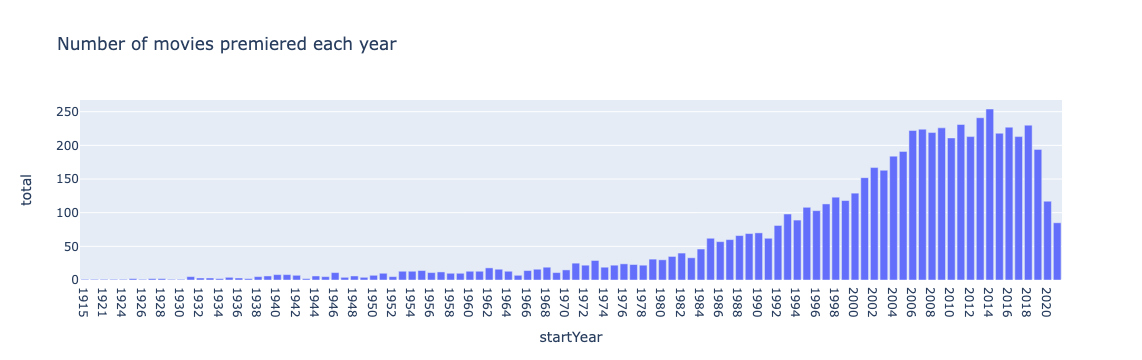

In [65]:
# Run this call to generate the bar plot.
px.bar(res_q1b, x="startYear", y="total", title="Number of movies premiered each year")

<br/><br/>

---

## Question 2

Who are the **top 10 most prolific movie actors**?

Define the term **"movie actor"** is defined as anyone with an `"actor"` or `"actress"` job category role in a `"movie"` title type.

Your SQL query should output exactly two fields named `name` (the movie actor name) and `total` (the number of movies the movie actor appears in). Order the records by `total` in descending order, and break ties by ordering by `name` in ascending order.

Your result should look something like the following, but without `????`:

| | name | total |
|-----|-----|-----|
|**0**| ???? | 64 |
|**1**| ???? | 54 |
|**2**| ???? | 53 |
|**3**| ???? | 49 |
|**4**| ???? | 46 |
|**5**| ???? | 43 |
|**6**| ???? | 41 |
|**7**| ???? | 40 |
|**8**| ???? | 40 |
|**9**| ???? | 39 |

**Hints**:

* ***The query should take < 2 minutes to run.***
* Google the top of the list and see if it makes sense. (Since this is a mini version of IMDb, some may still be off.)
* If you want to include a non-aggregate field in the `SELECT` clause, it must also be included in the `GROUP BY` clause.

In [66]:
%%sql
SELECT name.primaryName AS name, COUNT(*) AS total
FROM name
JOIN role ON name.nconst = role.nconst
JOIN title ON role.tconst = title.tconst
WHERE title.titleType = 'movie' AND role.category IN ('actor', 'actress')
GROUP BY name.primaryName
ORDER BY total DESC, name.primaryName ASC
LIMIT 10;

 * sqlite:///../../../../../../../tmp/imdbmini.db
Done.


name,total
Robert De Niro,64
Samuel L. Jackson,54
Nicolas Cage,53
Bruce Willis,49
Tom Hanks,46
Johnny Depp,43
Mark Wahlberg,41
Liam Neeson,40
Morgan Freeman,40
Adam Sandler,39


In [67]:
query_q2 = """
SELECT name.primaryName AS name, COUNT(*) AS total
FROM name
JOIN role ON name.nconst = role.nconst
JOIN title ON role.tconst = title.tconst
WHERE title.titleType = 'movie' AND role.category IN ('actor', 'actress')
GROUP BY name.primaryName
ORDER BY total DESC, name.primaryName ASC
LIMIT 10;
"""


res_q2 = pd.read_sql(query_q2, engine)
res_q2

,name,total
0,Robert De Niro,64
1,Samuel L. Jackson,54
2,Nicolas Cage,53
3,Bruce Willis,49
4,Tom Hanks,46
5,Johnny Depp,43
6,Mark Wahlberg,41
7,Liam Neeson,40
8,Morgan Freeman,40
9,Adam Sandler,39


In [68]:
grader.check("q2")

q2 results: All test cases passed!

<br/><br/>

---

## Question 3: The `CASE` Keyword

The `Rating` table has the `numVotes` and the `averageRating` for each title. A movie is consider a **"big hit**" if there were more than 100,000 votes for the movie. Which `movie` titles were **"big hits"**? Construct a query that generates the following result:

| | isBigHit | total |
|-----|-----|-----|
|**0**| no | ???? |
|**1**| yes | ???? |

Where `????` is replaced with the correct values. The row with `no` should have the count for how many movies **are not** big hits, and the row with `yes` should have the count of how many movies **are** big hits.

**Hints**:

* While SQL sometimes cast data automatically, it is still best practice to cast string data to numerical data type manually before performing arithmetic operation for the purposes of readability and reproducibility.
* You will need to use some type of `JOIN`.
* You may also consider using a `CASE` statement:
    ```
    CASE 
        WHEN ... THEN ...
        ELSE ... 
    END
    ```
 `CASE` statements are the SQL-equivalent of Python `if... elif... else` statements. To read up on `CASE`, take a look at the following links:
    - https://mode.com/sql-tutorial/sql-case/
    - https://www.w3schools.com/sql/sql_ref_case.asp


In [69]:
%%sql
SELECT 
    CASE
        WHEN CAST(rating.numVotes AS int) > 100000 THEN 'yes'
        ELSE 'no'
    END AS isBigHit,
    COUNT(*) AS total
FROM rating
LEFT JOIN title ON rating.tconst = title.tconst
WHERE title.Titletype = 'movie'
GROUP BY isBigHit;

 * sqlite:///../../../../../../../tmp/imdbmini.db
Done.


isBigHit,total
no,4318
yes,2041


In [70]:
query_q3 = """
SELECT 
    CASE
        WHEN CAST(rating.numVotes AS int) > 100000 THEN 'yes'
        ELSE 'no'
    END AS isBigHit,
    COUNT(*) AS total
FROM rating
LEFT JOIN title ON rating.tconst = title.tconst
WHERE title.Titletype = 'movie'
GROUP BY isBigHit;
"""


res_q3 = pd.read_sql(query_q3, engine)
res_q3

,isBigHit,total
0,no,4318
1,yes,2041


In [71]:
grader.check("q3")

q3 results: All test cases passed!

<br/><br/>

---

## Question 4

**How does movie length relate to ratings?**  To answer this question we want to bin `movie` titles by length, compute the average of the average ratings within each length bin, and visualize the relations.

### Question 4a

We will group movies by 10-minute increments -- that is, one bin for movies \[0, 10) minutes long, another for \[10, 20) minutes, another for \[20, 30) minutes, and so on. Use the following code snippet to help construct 10-minute bins: 

```
ROUND(runtimeMinutes / 10.0 + 0.5) * 10 AS runtimeBin
```

Construct a query that generates a resulting table containing the **`runtimeBin`**, the **average** of the **average ratings** (as `averageRating`), the **average number of votes** (as `averageNumVotes`), and the number of `titles` in that **runtimeBin** (as `total`).  Only include movies with **at least 10000 votes**.  Order the final results by the value of `runtimeBin`.

**Hint**:
* You can use a variable(s) defined in your `SELECT` clause in the later part of your query.

In [74]:
%%sql
SELECT 
    ROUND(runtimeMinutes / 10.0 + 0.5) * 10 AS runtimeBin, 
    averageRating, 
    AVG(numVotes) AS averageNumVotes, 
    COUNT(*) AS total
FROM title
JOIN rating ON title.tconst = rating.tconst
WHERE title.Titletype = 'movie' AND rating.numVotes >= 100000
GROUP BY runtimeBin;

 * sqlite:///../../../../../../../tmp/imdbmini.db
Done.


runtimeBin,averageRating,averageNumVotes,total
50.0,8.2,42535.0,2
60.0,6.5,30668.5,2
70.0,8.3,59822.0,13
80.0,8.1,67896.1875,64
90.0,8.5,76907.60846560847,567
100.0,7.9,82147.24259131633,1451
110.0,7.9,99912.44093406593,1456
120.0,8.1,121878.85508550855,1111
130.0,7.9,152911.96801112656,719
140.0,7.7,181664.82511210762,446


In [75]:
query_q4 = """
SELECT 
    ROUND(runtimeMinutes / 10.0 + 0.5) * 10 AS runtimeBin, 
    averageRating, 
    AVG(numVotes) AS averageNumVotes, 
    COUNT(*) AS total
FROM title
JOIN rating ON title.tconst = rating.tconst
WHERE title.Titletype = 'movie' AND rating.numVotes >= 100000
GROUP BY runtimeBin;
"""


res_q4 = pd.read_sql(query_q4, engine)
res_q4.head()

,runtimeBin,averageRating,averageNumVotes,total
0,50.0,8.2,42535.000000,2
1,60.0,6.5,30668.500000,2
2,70.0,8.3,59822.000000,13
3,80.0,8.1,67896.187500,64
4,90.0,8.5,76907.608466,567


In [76]:
grader.check("q4a")

q4a results: All test cases passed!

<br><br>

Let us take a look at the current distribution of movie runtimes.

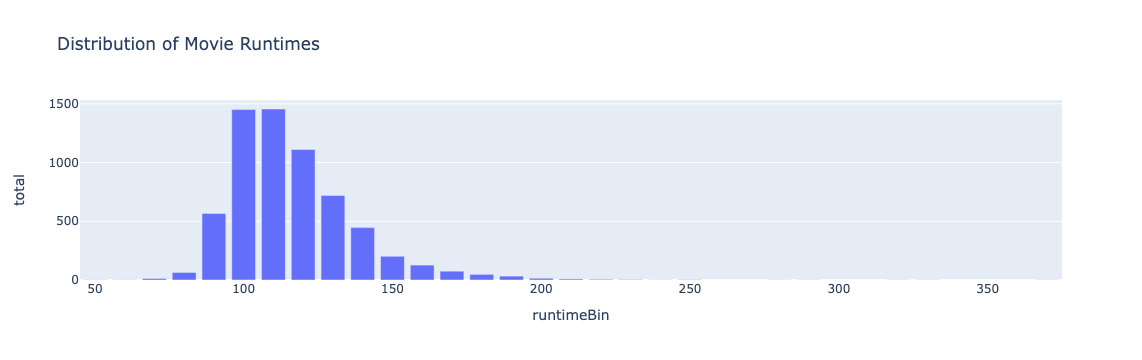

In [77]:
px.bar(res_q4, x="runtimeBin", y="total", title="Distribution of Movie Runtimes")

<!-- BEGIN QUESTION -->

<br><br>

---

### Question 4b

Create two line plots below. The first should show the relationship between the number of votes vs runtime; and the second will show the relationship between average rating and runtime. Use the columns from the table generated in the previous part, `res_q4`. If your SQL query is correct you should get some interesting plots below. This might explain why directors keep going with a particular range of runtimes. 

**Note**:
Please use `sns` or `plt` functions as plotly `px` will not export well to the PDF. Please include desciptive titles and labels. 

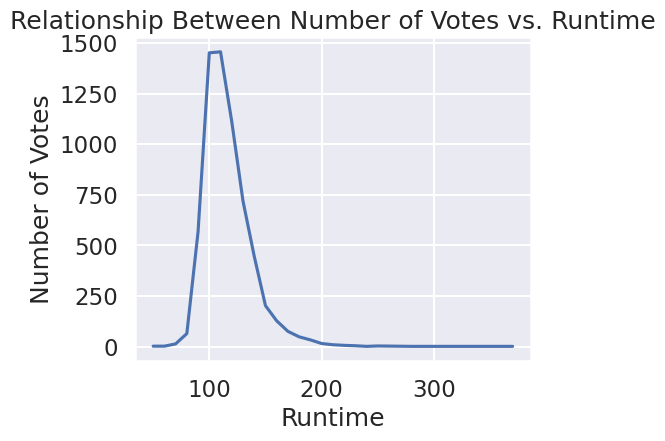

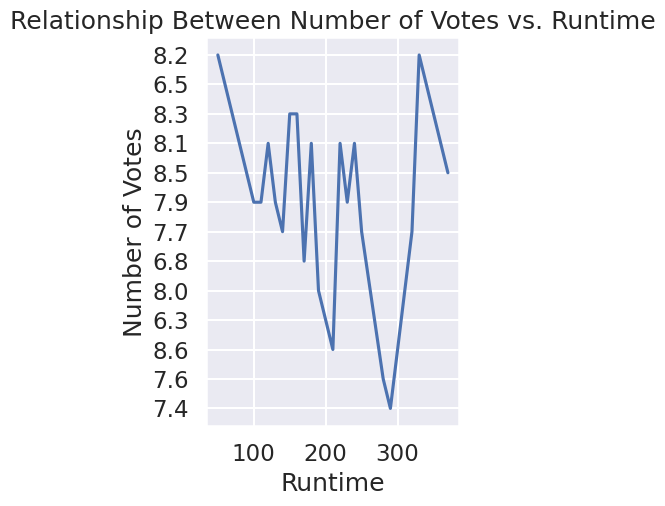

In [78]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1) # DO NOT MODIFY THIS LINE
sns.lineplot(x = 'runtimeBin', y = 'total', data = res_q4)
plt.title('Relationship Between Number of Votes vs. Runtime')
plt.xlabel('Runtime')
plt.ylabel('Number of Votes')
plt.show()
plt.subplot(1, 2, 2) # DO NOT MODIFY THIS LINE
sns.lineplot(x = 'runtimeBin', y = 'averageRating', data = res_q4)
plt.title('Relationship Between Number of Votes vs. Runtime')
plt.xlabel('Runtime')
plt.ylabel('Number of Votes')
plt.show()

<!-- END QUESTION -->

<br/><br/>

---

## Question 5


Which **movie actors** have the highest average ratings across all the movies in which they star? Again, define **"movie actor"** as anyone with an `actor` or `actress` job category role in a `movie` title type.

Construct a query that generates a resulting table consisting of the **movie actor's name**  (as `name`) and their **average actor rating** (as `actorRating`) computed by rescaling ratings for movies in which they had a role:

$$
\text{actorRating} = 
\frac{\sum_m \text{averageRating}[m] * \text{numVotes}[m]}{\sum_m \text{numVotes}[m]}
$$

In addition, only consider ratings where there are **at least 1000** votes and only consider movie actors that have **at least 20 rated performances**. Present the movie actors with the **top 10** `actorRating` in descending order and break ties alphabetically using the movie actor's name.

The results should look something like this but without the `????`, and with higher rating precision.

| | name | actorRating |
|-----|-----|-----|
|**0**|????|8.4413...|
|**1**|????|8.2473...|
|**2**|????|8.1383...|
|**3**|????|8.1339...|
|**4**|????|8.0349...|
|**5**|????|7.9898...|
|**6**|????|7.9464...|
|**7**|????|7.9330...|
|**8**|????|7.9261...|
|**9**|????|7.8668...|


**Note**:
* ***The query should take < 3 minutes to run.***
* If an actor/actress has multiple `role` listings for a movie, then that movie will have a bigger impact in the overall average (this is desired).

In [82]:
%%sql
SELECT 
    primaryName AS name,
    SUM(averageRating * numVotes) / SUM(numVotes) AS actorRating
FROM name
JOIN role ON name.nconst = role.nconst
JOIN rating ON role.tconst = rating.tconst
JOIN title ON rating.tconst = title.tconst
WHERE rating.numVotes >= 10000 
    AND title.Titletype = 'movie' 
    AND role.category IN ('actor', 'actress') 
GROUP BY primaryName
HAVING COUNT(*) >= 20
ORDER BY actorRating DESC, name ASC
LIMIT 10;

 * sqlite:///../../../../../../../tmp/imdbmini.db
Done.


name,actorRating
Diane Keaton,8.441302223858013
Tim Robbins,8.247318384970836
Al Pacino,8.138361195580254
Michael Caine,8.13391512838329
Leonardo DiCaprio,8.034960968967019
Christian Bale,7.989825204141808
Robert Duvall,7.9464826692188995
Jack Nicholson,7.933033651440138
Kevin Spacey,7.926157790005811
Clint Eastwood,7.8668385210673994


In [83]:
query_q5 = """
SELECT 
    primaryName AS name,
    SUM(averageRating * numVotes) / SUM(numVotes) AS actorRating
FROM name
JOIN role ON name.nconst = role.nconst
JOIN rating ON role.tconst = rating.tconst
JOIN title ON rating.tconst = title.tconst
WHERE rating.numVotes >= 10000 
    AND title.Titletype = 'movie' 
    AND role.category IN ('actor', 'actress') 
GROUP BY primaryName
HAVING COUNT(*) >= 20
ORDER BY actorRating DESC, name ASC
LIMIT 10;
"""


res_q5 = pd.read_sql(query_q5, engine)
res_q5

,name,actorRating
0,Diane Keaton,8.441302
1,Tim Robbins,8.247318
2,Al Pacino,8.138361
3,Michael Caine,8.133915
4,Leonardo DiCaprio,8.034961
5,Christian Bale,7.989825
6,Robert Duvall,7.946483
7,Jack Nicholson,7.933034
8,Kevin Spacey,7.926158
9,Clint Eastwood,7.866839


In [84]:
grader.check("q5")

q5 results: All test cases passed!

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />


## Congratulations! You finished Homework 8!

Below, you will see two cells. Running the first cell will automatically generate a PDF of all questions that need to be manually graded, and running the second cell will automatically generate a zip with your autograded answers. **You are responsible for both the coding portion (the zip from Homework 8) and the written portion (the PDF with from Homework 8) to their respective Gradescope portals.** The coding proportion should be submitted to Homework 8 Coding as a single zip file, and the written portion should be submitted to Homework 8 Written as a single pdf file. When submitting the written portion, please ensure you select pages appropriately and check all plots appear. 

If there are issues with automatically generating the PDF in the first cell, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. Either way, **you are responsible for ensuring your submission follows our requirements, we will NOT be granting regrade requests for submissions that don't follow instructions.**

In [85]:
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("hw08.ipynb", filtering=True, pagebreaks=True)
if(path.exists('hw08.pdf')):
    display(HTML("Download your PDF <a href='hw08.pdf' download>here</a>."))
else:
    print("\n Pdf generation fails, please try the other methods described above")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [86]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...

Your submission received the following results when run against available test cases:

    q1a results: All test cases passed!

    q1b results: All test cases passed!

    q2 results: All test cases passed!

    q3 results: All test cases passed!

    q4a results: All test cases passed!

    q5 results: All test cases passed!
